# DSCI445 Term Project - Bank Account Fraud Detection
### Jakob Wickham, Nick Brady, Noah Sturgeon

This was hell to work on

To whoever wants to update this, read here to know how to make slides: https://www.geeksforgeeks.org/creating-interactive-slideshows-in-jupyter-notebooks/

In [1]:
import pandas as pd, kagglehub

In [2]:
# Only run if you want to locally have the dataset on your machine
path = kagglehub.dataset_download("sgpjesus/bank-account-fraud-dataset-neurips-2022")

data: pd.DataFrame = pd.read_csv(f"{path}/Base.csv")

## 1. Introduction

Fraud detection is a pretty important, yet very volatile system. With there being so many factors that can easily blend in with each other, how can one tell if a transaction was actually from the account's owner?

### The Dataset

The Bank Account Fraud (BAF) NeurIPS 2022 datasets are a collection of based-on-reality simulated datasets emulate real-world bank fraud data. Included is 32 columns, with 31 features and a classification column stating whether or not the transaction was fraudulent or not.

As with something like fraud detection, it's a very imbalanced dataset, containing mostly of non-fraudulent transactions and very few fraudulent ones. This was the start of the many hurdles we had to overcome.

In [10]:
pd.DataFrame(data.groupby(data['fraud_bool'])['fraud_bool'].count())

,fraud_bool
fraud_bool,
0,988971
1,11029


Because the data is imbalanced, a lot of normal techniques can't be easily performed on the dataset. Simple algorithms like logistic regression, K-nearest neighbors, or random forests don't perform well with the raw dataset as is.

On top of that, any general measurement to determine performance on those models meant nothing: accuracy, recall, precision, the likes; they only worked great on the non-fraud transactions. So, we had to do some digging into the dataset to see what we can do to make this better.

### Data Cleaning

So what are some features that we can remove without much worry?

Well, there's this feature:

In [6]:
pd.DataFrame(data.groupby(["device_fraud_count"])["fraud_bool"].count())

,fraud_bool
device_fraud_count,
0,1000000


It's all 0, so that's an easy feature to get rid of. But the rest have some values and meaning to them, so let's explore some more.

Some numerical features in this dataset contain invalid values. Let's check how many numerical features have a majority of their data missing or invalid:

In [ ]:
numeric_missing_value_columns = ['prev_address_months_count', 'current_address_months_count', 'intended_balcon_amount', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']

missing_data_summary = pd.DataFrame({
    'Missing Data Count': [(data[col] < 0).sum() for col in numeric_missing_value_columns],
    'Percentage Missing': [(data[col] < 0).mean() * 100 for col in numeric_missing_value_columns]
}, index=numeric_missing_value_columns)

missing_data_summary.sort_values(by='Percentage Missing', ascending=False)

,Missing Data Count,Percentage Missing
intended_balcon_amount,742523,74.2523
prev_address_months_count,712920,71.2920
bank_months_count,253635,25.3635
current_address_months_count,4254,0.4254
session_length_in_minutes,2015,0.2015
device_distinct_emails_8w,359,0.0359


`intended_balcon_amount` and `prev_address_months_count` have a majority of their data as invalid or missing. We decided to get rid of these columns for that reason.

The rest of those columns we decided to impute to give those invalid values some meaning by replacing it with the median data of that column. Some models don't work well with missing data, so this was necessary.

We looked into doing some feature engineering by adding some dummy columns for various features, but decided to forgo this because it didn't provide much help to our results

So with that out of the way, that's it right? The data's good to be thrown into some models?

### Exploratory Data Analysis

If only it were that easy.

We decided to do some basic EDA to see if there were any features--hopefully one--that correlated highly toward fraudulent transactions, so we made correlation matrices for fraudulent and non-fraudulent transactions.

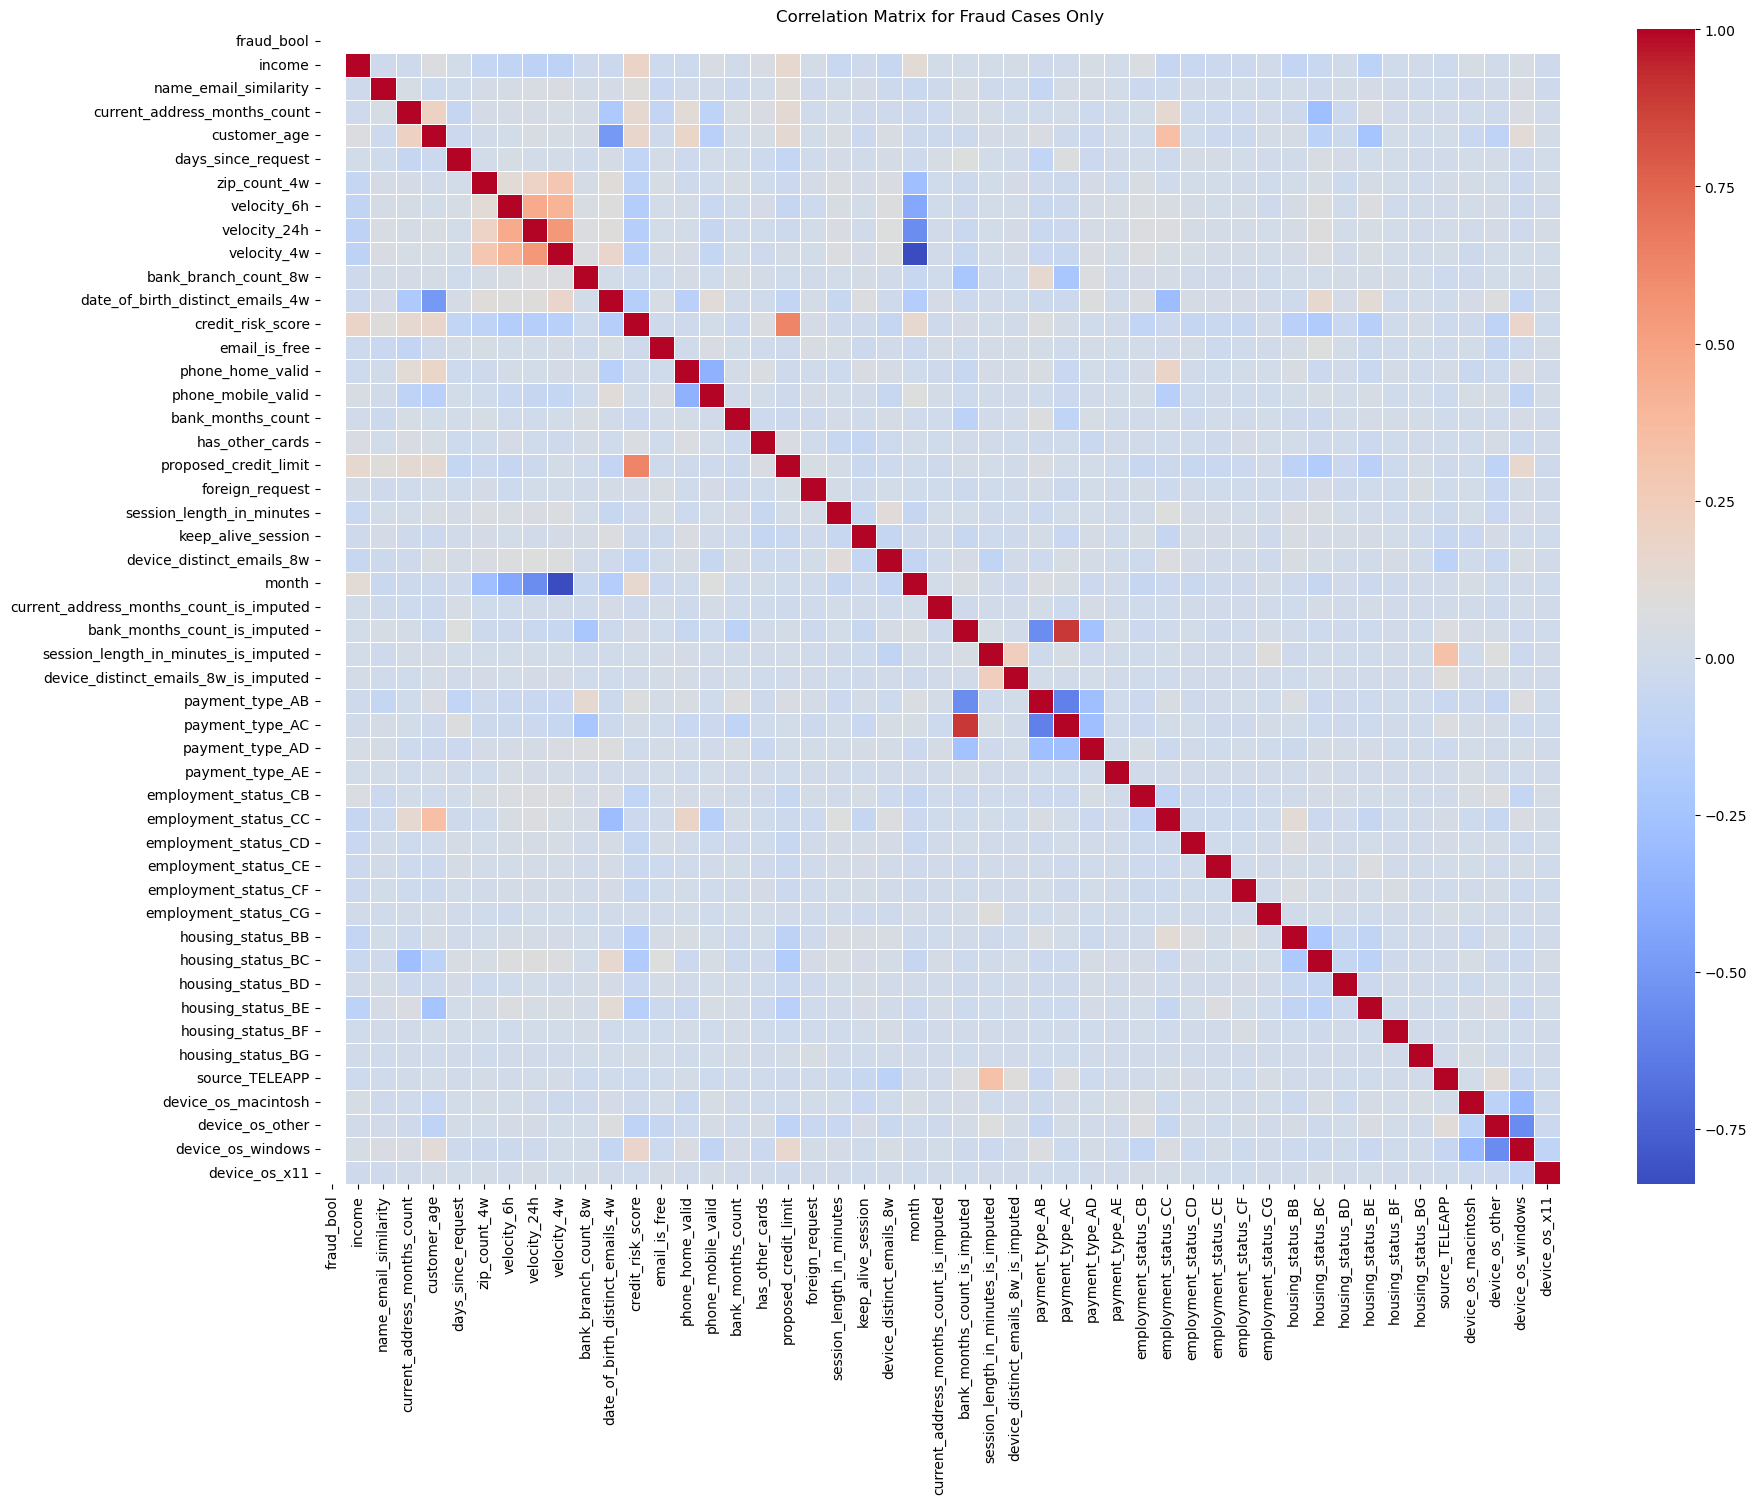

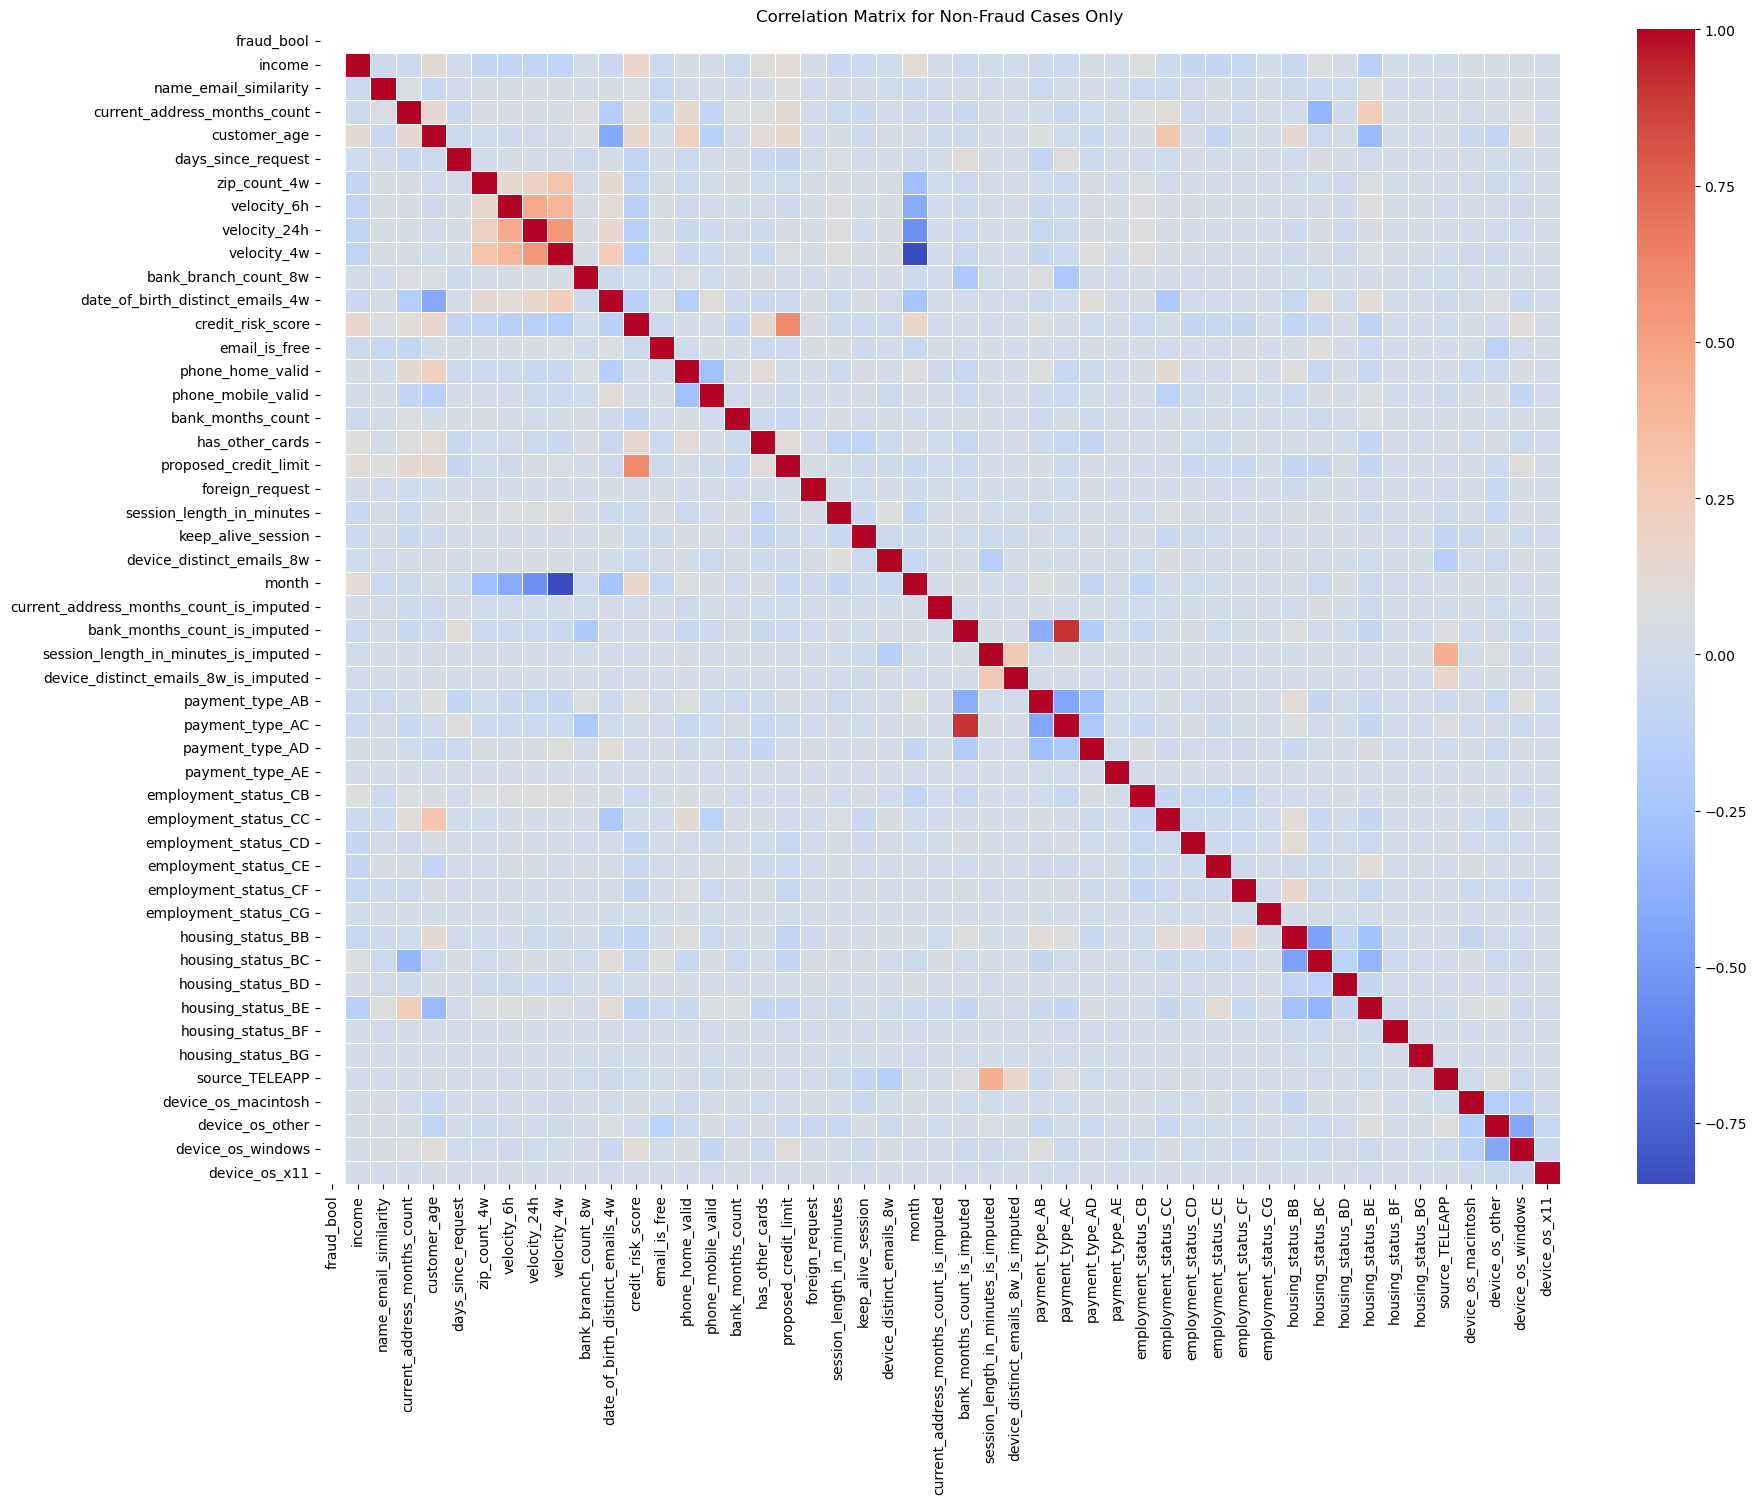

What we wanted to see was if there were any correlations between features that had a big correlation change between fraudulent and non-fradulent transactions, but we didn't see any.

So we resorted to using every predictor we had (minus the ones we removed) into our models to see what came of it. And thus began the start of the descent into madness.

## 2. Naively Fitting Models

To start off the model selection, we wanted to see how bad models on the imbalanced data performed without proper techniques. We chose four models:

* Logistic Regression (the simplest classifier)

* K-Nearest Neighbors (the simplest non-parametric classifier)

* Decision Tree (because why not)

* Random Forest of 100 trees (our most complex method we have)

We would've loved to use a SVC, GAM, or some other highly complicated method, but we only have so much computing power on our hands and a million rows to throw at these models.

So, how did these models perform on the cleaned-up imbalanced dataset?

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Model</th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>Recall @5% FPR</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>LogisticRegression</td>
      <td>0.988890</td>
      <td>0.447368</td>
      <td>0.007665</td>
      <td>0.504959</td>
    </tr>
    <tr>
      <th>1</th>
      <td>KNeighborsClassifier</td>
      <td>0.988840</td>
      <td>0.150000</td>
      <td>0.001353</td>
      <td>0.294612</td>
    </tr>
    <tr>
      <th>2</th>
      <td>DecisionTreeClassifier</td>
      <td>0.977435</td>
      <td>0.075157</td>
      <td>0.091524</td>
      <td>0.125908</td>
    </tr>
    <tr>
      <th>3</th>
      <td>RandomForestClassifier</td>
      <td>0.988900</td>
      <td>0.333333</td>
      <td>0.000902</td>
      <td>0.445812</td>
    </tr>
  </tbody>
</table>
</div>

Everything here is about what you'd expect for an imbalanced dataset:

* High accuracy (it's classifying the non-fraud data very consistently)

* Varying precision levels (classifies more false positives than true positives overall)

* Horrible recall levels (classifies fraud data as non-fraud data, aka a false negative)

The final column interpolates the recall rate if we were sticking to a 5% false positive rate (FPR), which leads to another problem with imbalanced data: the **recall-FPR tradeoff**

Similarly to how the bias-variance tradeoff focuses on whether a model fits the data too well or too poorly, the recall-FPR tradeoff focuses on whether it makes more false positives (non-fraud -> fraud, actually non-fraud) or false negatives (fraud -> non-fraud, actually fraud), and it's a key tradeoff to handle when it comes to tuning models.

Since our data is heavily imbalanced, we want to be able to correctly identify fraudulent data as such while still trying to keep a low false positive rate, so we want to focus on making our recall rate as high as we can while still maintaining our desired goal of 5% FPR. *foreshadowing*

So how do we handle imbalanced data correctly to be able to improve our recall rate? Through proper imbalanced data handling techniques, that's how.

## 3. Imbalanced Data Handling

There are many ways to handle imbalanced data and prepare it before putting it into a model, and here is a list of some of the ones we tested:

**SMOTE** (Synthetic Minority Over-sampling TEchnique): over-samples the minority class by computing synthetic datapoints for it

**ADASYN** (ADAptive SYNthetic Sampling): SMOTE, but adaptively computes more datapoints that are "harder to learn"

**Random Under-sampling**: Randomly under-samples the majority class with or without replacement

**SMOTE + Tomek's Links**: Over-sampling with SMOTE and under-sampling with Tomek's links (selects pairs of observations that are themselves neighbors but of different classes)

These are a few we tried for the project, and each of them performed alright to varying degrees.